##GPU Information

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! nvidia-smi

Sat Jul 24 10:35:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    30W /  70W |   8922MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Import Libs

In [ ]:
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import inception_resnet_v2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Input, Flatten, Conv2D, MaxPooling2D, Dense, UpSampling2D, GlobalAveragePooling2D, Dropout, BatchNormalization

#Params

In [ ]:
BATCH_SIZE = 32
NUM_CLASSES = 100
INPUT_SHAPE = (128, 128, 3)
LR = 0.001
EPOCHS = 20
COLORS = 3

#Preprocess Data

In [1]:
# load data
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

NameError: ignored

In [ ]:
plt.figure(figsize=(24, 8))
for i, img in enumerate(X_train[:10]):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(img)

plt.show()

In [ ]:
# preprocess input
x_train = inception_resnet_v2.preprocess_input(X_train)
x_test = inception_resnet_v2.preprocess_input(X_test)

# one-hot output
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train)
y_test = onehot.transform(y_test)

In [ ]:
plt.figure(figsize=(24, 8))
for i, img in enumerate(x_train[:10]):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(img.clip(0., 255.))

plt.show()

In [ ]:
# split dataset
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=10000, random_state=12)
print('Train size: \t', x_train.shape[0])
print('Valid size: \t', x_val.shape[0])
print('Test size: \t', x_test.shape[0])

#Define model

In [ ]:
# load base model 
base_model = inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_205 (BatchN (None, 127, 127, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 127, 127, 32) 0           batch_normalization_205[0][0]    
________________________________________________________________________________

In [ ]:
# define model
model = Sequential([
                    UpSampling2D(),
                    UpSampling2D(),
                    UpSampling2D(),
                    base_model,
                    GlobalAveragePooling2D(),
                    Dense(512, activation='relu'),
                    BatchNormalization(),
                    Dropout(0.2),
                    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model

In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/My Model'
!ls

/content/drive/MyDrive/Colab Notebooks/My Model
dog.png  ResNet-Cifar100.ipynb	saved_model.h5


In [ ]:
# callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
rlr = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, verbose=1, factor=0.2, min_delta=1e-5)
cp = ModelCheckpoint(filepath='saved_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

callbacks = [es, rlr, cp]

In [ ]:
# data augmentation
# augmentation for training data
aug_train = ImageDataGenerator(rotation_range=30, 
                               width_shift_range=0.1, 
                               height_shift_range=0.1, 
                               shear_range=0.2, 
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest')

In [ ]:
# train
H = model.fit(aug_train.flow(x_train, y_train, batch_size=BATCH_SIZE),
              steps_per_epoch=len(x_train)//BATCH_SIZE,
              validation_data=(x_val, y_val),
              epochs=EPOCHS,
              verbose=1,
              callbacks=callbacks)

Epoch 1/20
1250/1250 [==============================] - 1019s 815ms/step - loss: 2.6115 - accuracy: 0.3318 - val_loss: 2.0162 - val_accuracy: 0.4555

Epoch 00001: val_accuracy improved from -inf to 0.45550, saving model to saved_model.h5
Epoch 2/20
1250/1250 [==============================] - 1018s 814ms/step - loss: 1.7731 - accuracy: 0.5098 - val_loss: 1.7767 - val_accuracy: 0.5229

Epoch 00002: val_accuracy improved from 0.45550 to 0.52290, saving model to saved_model.h5
Epoch 3/20
1250/1250 [==============================] - 1014s 811ms/step - loss: 1.5173 - accuracy: 0.5681 - val_loss: 1.7800 - val_accuracy: 0.5355

Epoch 00003: val_accuracy improved from 0.52290 to 0.53550, saving model to saved_model.h5
Epoch 4/20
1250/1250 [==============================] - 1013s 810ms/step - loss: 1.3567 - accuracy: 0.6108 - val_loss: 1.4404 - val_accuracy: 0.5933

Epoch 00004: val_accuracy improved from 0.53550 to 0.59330, saving model to saved_model.h5
Epoch 5/20
1250/1250 [=================

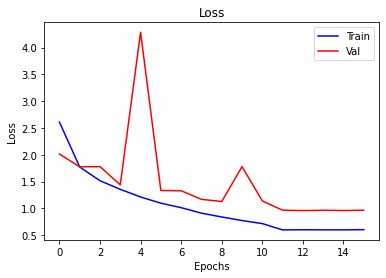

In [ ]:
# visualize model loss
plt.plot(H.history['loss'], 'b-')
plt.plot(H.history['val_loss'], 'r-')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.show()

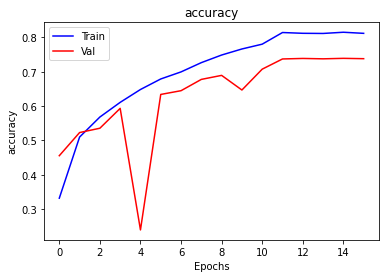

In [ ]:
# visualize model acccuracy
plt.plot(H.history['accuracy'], 'b-')
plt.plot(H.history['val_accuracy'], 'r-')
plt.title('accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Val'])
plt.ylabel('accuracy')
plt.show()

#Evaluate model

In [ ]:
# load best model
model = load_model('saved_model.h5')

In [ ]:
# evaluate
score = model.evaluate(x_test, y_test)
print('Test loss: \t', score[0])
print('Test accuracy: \t', score[1])

313/313 [==============================] - 103s 220ms/step - loss: 0.9893 - accuracy: 0.7284
Test loss: 	 0.9892882108688354
Test accuracy: 	 0.7283999919891357


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_6 (UpSampling2 (None, None, None, None)  0         
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, None, None, None)  0         
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, None, None, None)  0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               786944    
_________________________________________________________________
batch_normalization_408 (Bat (None, 512)              

# Visualize

##Visualize filters

In [ ]:
kernels = model.get_layer('inception_resnet_v2').get_weights()
filters = kernels[0]
np.array(filters).shape

(3, 3, 3, 32)

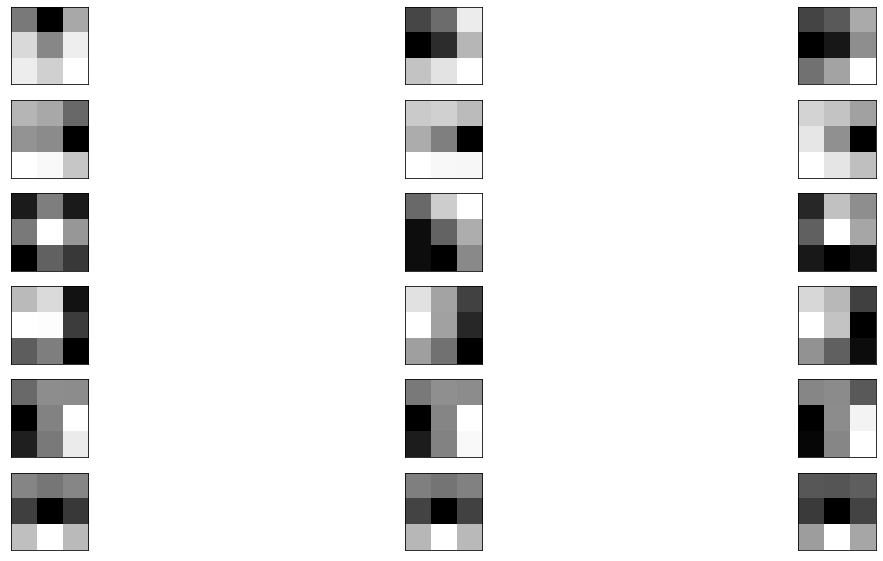

In [ ]:
# normalize filters
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Plot some filters
plt.figure(figsize=(20, 10))
n_filters = 6
idx = 1
for i in range(n_filters):
  filter = filters[:, :, :, i]
  for j in range(3): # draw each channel of filter
    plt.subplot(n_filters, 3, idx)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(filter[:, :, j], cmap='gray') # map to gray
    idx += 1

plt.show()

##Visualize feature maps

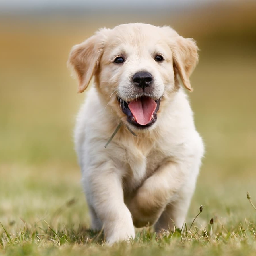

In [ ]:
# load and resize image
image = load_img('dog.png', target_size=(256, 256))
image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


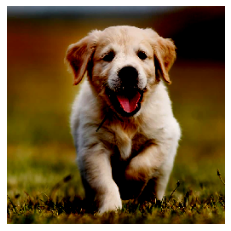

In [ ]:
# preprocess
image = inception_resnet_v2.preprocess_input(img_to_array(image))
plt.axis('off')
plt.imshow(image)

In [ ]:
image = expand_dims(image, axis = 0)
image.shape

(1, 256, 256, 3)

In [ ]:
# define a feature extractor
def my_init(shape, dtype=None):
    return tf.convert_to_tensor(filters)
  
input = Input(shape=(256, 256, 3))
output = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer=my_init)(input)
extractor = Model(inputs=input, outputs=output)
extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# extract features
features = extractor.predict(image)
features.shape

(1, 256, 256, 32)

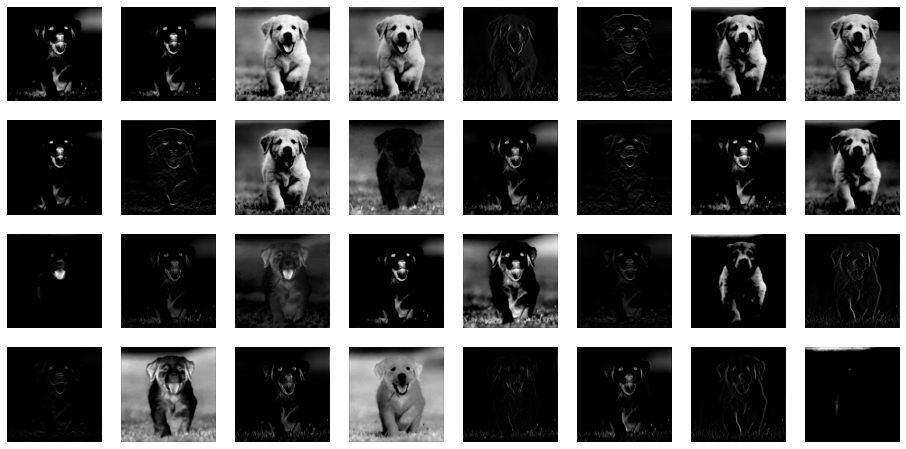

In [ ]:
# There are 32 feature maps correspond to 32 filters
# Plot feature maps
i = 1
plt.figure(figsize=(16, 8))
for _ in range(8):
  for _ in range(4):
    plt.subplot(4, 8, i)
    plt.axis('off')
    plt.imshow(features[0, :, :, i-1], cmap='gray') # map to gray color
    i += 1

plt.show()